# Build a random forest model

## Importing and exploration

In [ ]:
# pip install -U scikit-learn scipy matplotlib
# pip install numpy==1.21.4
# pip install numba==0.53.0
# pip install librosa
# pip install imbalanced-learn


# Feature engineering and build models
# Proportion of each injured age group depending on class
# Get familiar with PSNI dataset

In [ ]:

# pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=4fcf66a7b65a2c3e91dacdc219ac781b99336bcdd07837c22e417eb2383cc721
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score,roc_auc_score, average_precision_score, recall_score, precision_score
from sklearn import preprocessing
import seaborn as sns
# from scipy.stats import chi2_contingency
# import lime
# from lime import lime_tabular
# import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import dataset
updated_lats_longs = pd.read_csv('/content/drive/MyDrive/Internship/updated_lat_longs.csv', index_col = 0)
ni_accidents = pd.read_csv('/content/drive/MyDrive/Internship/ni_accidents_2021_wgoogle.csv',index_col=0,low_memory=False)

In [ ]:
ni_accidents.shape
# ni_accidents = pd.read_csv('ni_accidents_2021_wgoogle.csv',index_col=0,low_memory=False)
# updated_lats_longs = pd.read_csv("updated_lat_longs.csv", index_col = 0)

(71964, 56)

In [ ]:
# join two datasets together
updated_ni_accidents = pd.merge(ni_accidents, updated_lats_longs, how = "left",left_on=['lat','lon'], right_on = ['lats','longs'])
updated_ni_accidents[["address_x", "postcodes_x","location_infos_x"]] = np.where(updated_ni_accidents[["address_y", "postcodes_y","location_infos_y"]].isna(), updated_ni_accidents[["address_x", "postcodes_x","location_infos_x"]], updated_ni_accidents[["address_y","postcodes_y","location_infos_y"]])
updated_ni_accidents.drop(updated_ni_accidents.iloc[:, -5:], inplace = True, axis = 1)
updated_ni_accidents = updated_ni_accidents.rename(columns={"address_x": "address", "postcodes_x": "postcodes","location_infos_x":"location_infos"})

In [ ]:
updated_ni_accidents.shape

(71964, 56)

In [ ]:
# updated_ni_accidents.head(10)

In [ ]:
# drop duplicates
ni_accidents_removed = updated_ni_accidents.drop_duplicates()

In [ ]:
# drop columns that have too may missing values
nans = pd.DataFrame()
nans["num"] = ni_accidents_removed.isnull().sum()
nans["percent(%)"] = (nans["num"]/ni_accidents_removed.shape[0])*100
row_names = nans[nans["percent(%)"]>50].index
ni_accidents_removed.drop(row_names, inplace = True, axis = 1)

<ipython-input-9-b4ef60b5f560>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ni_accidents_removed.drop(row_names, inplace = True, axis = 1)


In [ ]:
ni_accidents_removed.shape

(71647, 36)

In [ ]:
ni_accidents_removed.head()

a_year  a_ref            a_District                    a_type  a_veh  \
0    2016      1   Newry, Mourne, Down   Slight injury collision      1   
1    2016      2  Derry City, Strabane   Slight injury collision      2   
3    2016      2  Derry City, Strabane   Slight injury collision      2   
5    2016      3      Ards, North Down  Serious injury collision      1   
7    2016      4          Belfast City   Slight injury collision      2   

   a_cas a_wkday  a_day  a_month  a_hour  ...   c_sex  c_agegroup  \
0      1     FRI      1        1       1  ...  Female       17-24   
1      1     FRI      1        1       3  ...     NaN         NaN   
3      1     FRI      1        1       3  ...  Female       35-44   
5      1     FRI      1        1       3  ...    Male       35-44   
7      2     FRI      1        1       3  ...     NaN         NaN   

             c_sever c_school  c_vtype        lat       lon  \
0   Slightly injured    Other      Car  54.379157 -5.685504   
1                NaN      NaN      NaN  55.019106 -7.294136   
3   Slightly injured    Other      Car  55.019106 -7.294136   
5  Seriously injured    Other      Car  54.476645 -5.692128   
7                NaN      NaN      NaN  54.593451 -5.887517   

                                             address postcodes  \
0         87 Killyleagh Rd, Downpatrick BT30 9UD, UK  BT30 9UD   
1                 Foyle Bridge, Londonderry BT48, UK      BT48   
3                 Foyle Bridge, Londonderry BT48, UK      BT48   
5  28 Comber Rd, Killinchy, Newtownards BT23 6PB, UK  BT23 6PB   
7          8/367 Beersbridge Rd, Belfast BT5 5EF, UK   BT5 5EF   

                                      location_infos  
0  ['street_address', 'establishment', 'point_of_...  
1  ['route', 'plus_code', 'premise', 'street_addr...  
3  ['route', 'plus_code', 'premise', 'street_addr...  
5  ['premise', 'street_address', 'establishment',...  
7  ['premise', 'establishment', 'health', 'point_...  

[5 rows x 36 columns]

In [ ]:
ni_accidents_removed = ni_accidents_removed[ni_accidents_removed["c_sever"].notna()]

In [ ]:
ni_accidents_removed

a_year  a_ref                 a_District                    a_type  \
0        2016      1        Newry, Mourne, Down   Slight injury collision   
3        2016      2       Derry City, Strabane   Slight injury collision   
5        2016      3           Ards, North Down  Serious injury collision   
8        2016      4               Belfast City   Slight injury collision   
9        2016      4               Belfast City   Slight injury collision   
...       ...    ...                        ...                       ...   
71956    2021   4700  Lisburn, Castlereagh City   Slight injury collision   
71958    2021   4701                 Mid Ulster   Slight injury collision   
71959    2021   4702               Belfast City   Slight injury collision   
71960    2021   4703       Antrim, Newtownabbey  Serious injury collision   
71961    2021   4703       Antrim, Newtownabbey  Serious injury collision   

       a_veh  a_cas a_wkday  a_day  a_month  a_hour  ...   c_sex  c_agegroup  \
0          1      1     FRI      1        1       1  ...  Female       17-24   
3          2      1     FRI      1        1       3  ...  Female       35-44   
5          1      1     FRI      1        1       3  ...    Male       35-44   
8          2      2     FRI      1        1       3  ...    Male       45-54   
9          2      2     FRI      1        1       3  ...    Male       25-34   
...      ...    ...     ...    ...      ...     ...  ...     ...         ...   
71956      2      1     WED     14        7      20  ...  Female       17-24   
71958      1      1     FRI     13        8       3  ...    Male       25-34   
71959      1      1     TUE      7        9      17  ...  Female       35-44   
71960      2      2     WED     15        9      23  ...    Male       25-34   
71961      2      2     WED     15        9      23  ...    Male       25-34   

                 c_sever c_school                        c_vtype        lat  \
0       Slightly injured    Other                            Car  54.379157   
3       Slightly injured    Other                            Car  55.019106   
5      Seriously injured    Other                            Car  54.476645   
8       Slightly injured    Other                            Car  54.593451   
9       Slightly injured    Other                            Car  54.593451   
...                  ...      ...                            ...        ...   
71956   Slightly injured    Other                            Car  54.565303   
71958   Slightly injured    Other                            Car  54.757221   
71959   Slightly injured    Other  Bus or coach (17+ passengers)  54.595441   
71960  Seriously injured    Other                            Car  54.641153   
71961   Slightly injured    Other                            Car  54.641153   

            lon                                            address postcodes  \
0     -5.685504         87 Killyleagh Rd, Downpatrick BT30 9UD, UK  BT30 9UD   
3     -7.294136                 Foyle Bridge, Londonderry BT48, UK      BT48   
5     -5.692128  28 Comber Rd, Killinchy, Newtownards BT23 6PB, UK  BT23 6PB   
8     -5.887517          8/367 Beersbridge Rd, Belfast BT5 5EF, UK   BT5 5EF   
9     -5.887517          8/367 Beersbridge Rd, Belfast BT5 5EF, UK   BT5 5EF   
...         ...                                                ...       ...   
71956 -5.911502  Drunkeen Complex, Upper Galwally, Belfast BT8 ...   BT8 6FY   
71958 -6.507611             70 Creagh Rd, Magherafelt BT45 8EW, UK  BT45 8EW   
71959 -5.901743           185 Albertbridge Rd, Belfast BT5 4PW, UK   BT5 4PW   
71960 -6.055369                 Clady Corner, Crumlin BT29 4UN, UK  BT29 4UN   
71961 -6.055369                 Clady Corner, Crumlin BT29 4UN, UK  BT29 4UN   

                                          location_infos  
0      ['street_address', 'establishment', 'point_of_...  
3      ['route', 'plus_code', 'premise', 'street_addr...  
5      ['premise', 'street_address

In [ ]:
# ni_accidents_removed["c_sever"] = ni_accidents_removed["c_sever"].fillna(ni_accidents_removed["a_type"])

In [ ]:
ni_accidents_removed["casualty_injury_type"] = np.where((ni_accidents_removed["c_sever"] == "Slightly injured")|(ni_accidents_removed["c_sever"] == "Slight injury collision") ,0,1)

In [ ]:
ni_accidents_removed["collision_id"] = ni_accidents_removed["a_year"]*10000+ni_accidents_removed["a_ref"]

In [ ]:
ni_accidents_removed["casualty_injury_type"].value_counts()

0    42359
1     3887
Name: casualty_injury_type, dtype: int64

In [ ]:
ni_accidents_removed["collision_id"].head()

0    20160001
3    20160002
5    20160003
8    20160004
9    20160004
Name: collision_id, dtype: int64

In [ ]:
ni_accidents_removed

a_year  a_ref                 a_District                    a_type  \
0        2016      1        Newry, Mourne, Down   Slight injury collision   
3        2016      2       Derry City, Strabane   Slight injury collision   
5        2016      3           Ards, North Down  Serious injury collision   
8        2016      4               Belfast City   Slight injury collision   
9        2016      4               Belfast City   Slight injury collision   
...       ...    ...                        ...                       ...   
71956    2021   4700  Lisburn, Castlereagh City   Slight injury collision   
71958    2021   4701                 Mid Ulster   Slight injury collision   
71959    2021   4702               Belfast City   Slight injury collision   
71960    2021   4703       Antrim, Newtownabbey  Serious injury collision   
71961    2021   4703       Antrim, Newtownabbey  Serious injury collision   

       a_veh  a_cas a_wkday  a_day  a_month  a_hour  ...            c_sever  \
0          1      1     FRI      1        1       1  ...   Slightly injured   
3          2      1     FRI      1        1       3  ...   Slightly injured   
5          1      1     FRI      1        1       3  ...  Seriously injured   
8          2      2     FRI      1        1       3  ...   Slightly injured   
9          2      2     FRI      1        1       3  ...   Slightly injured   
...      ...    ...     ...    ...      ...     ...  ...                ...   
71956      2      1     WED     14        7      20  ...   Slightly injured   
71958      1      1     FRI     13        8       3  ...   Slightly injured   
71959      1      1     TUE      7        9      17  ...   Slightly injured   
71960      2      2     WED     15        9      23  ...  Seriously injured   
71961      2      2     WED     15        9      23  ...   Slightly injured   

       c_school                        c_vtype        lat       lon  \
0         Other                            Car  54.379157 -5.685504   
3         Other                            Car  55.019106 -7.294136   
5         Other                            Car  54.476645 -5.692128   
8         Other                            Car  54.593451 -5.887517   
9         Other                            Car  54.593451 -5.887517   
...         ...                            ...        ...       ...   
71956     Other                            Car  54.565303 -5.911502   
71958     Other                            Car  54.757221 -6.507611   
71959     Other  Bus or coach (17+ passengers)  54.595441 -5.901743   
71960     Other                            Car  54.641153 -6.055369   
71961     Other                            Car  54.641153 -6.055369   

                                                 address postcodes  \
0             87 Killyleagh Rd, Downpatrick BT30 9UD, UK  BT30 9UD   
3                     Foyle Bridge, Londonderry BT48, UK      BT48   
5      28 Comber Rd, Killinchy, Newtownards BT23 6PB, UK  BT23 6PB   
8              8/367 Beersbridge Rd, Belfast BT5 5EF, UK   BT5 5EF   
9              8/367 Beersbridge Rd, Belfast BT5 5EF, UK   BT5 5EF   
...                                                  ...       ...   
71956  Drunkeen Complex, Upper Galwally, Belfast BT8 ...   BT8 6FY   
71958             70 Creagh Rd, Magherafelt BT45 8EW, UK  BT45 8EW   
71959           185 Albertbridge Rd, Belfast BT5 4PW, UK   BT5 4PW   
71960                 Clady Corner, Crumlin BT29 4UN, UK  BT29 4UN   
71961                 Clady Corner, Crumlin BT29 4UN, UK  BT29 4UN   

                                          location_infos casualty_injury_type  \
0      ['street_address', 'establishment', 'point_of_...                    0   
3      ['route', 'plus_code', 'premise', 'street_addr...                    0   
5      ['premise', 'street_address', 'establishment',...                    1   
8      ['premise', 'establishment', 'health', 'point_...                    0   
9      ['premise', 'establishment'

## Regrouping variables
**Predictors**:
- a_hour (Hour of Collision (24 hour))
- a_month (Month of Collision)
- a_speed (Speed Limit)
- a_wkday (Weekday of Collision)
- a_District (Policing Area - at council level)
- v_man (Vehicle Manoeuvre)
- v_loc (Vehicle Location at Time of Impact)
- v_impact (First Point of Impact)
- v_agegroup (Age of Driver)
- v_sex (Sex of Driver)
- v_type (Vehicle Type)
- c_sex (Sex of Casualty)
- c_class (Casualty Class)
- c_vtype (Casualty Vehicle Type)
- location_infos:see if the following locations exist
  - car_repair
  - lodging
  - health
  - park
  - university


### a_hour

In [ ]:
# a_hour
ni_accidents_removed["a_hour_grouped"] = np.where(ni_accidents_removed["a_hour"].between(1,6, inclusive = 'both'),"night",
                                      np.where(ni_accidents_removed["a_hour"].between(7,12, inclusive =  'both'),"morning",
                                              np.where(ni_accidents_removed["a_hour"].between(13,18, inclusive =  'both'),"afternoon", "evening")))


In [ ]:


ni_accidents_removed["a_hour_grouped"].value_counts()

afternoon    22147
morning      13402
evening       8400
night         2297
Name: a_hour_grouped, dtype: int64

### a_month

In [ ]:
# a_month
ni_accidents_removed["a_month_grouped"] = np.where(ni_accidents_removed["a_month"].isin([3,4,5]),"spring",
                                                  np.where(ni_accidents_removed["a_month"].isin([6,7,8]),"summer",
                                                          np.where(ni_accidents_removed["a_month"].isin([9,10,11]),"autumn", "winter")))

In [ ]:
ni_accidents_removed["a_month_grouped"].value_counts()

autumn    12186
summer    11763
winter    11688
spring    10609
Name: a_month_grouped, dtype: int64

### a_speed

In [ ]:
ni_accidents_removed["a_speed_grouped"] = np.where(ni_accidents_removed["a_speed"]<=30, "urban speed", "rural speed")

In [ ]:
ni_accidents_removed["a_speed_grouped"].value_counts()

rural speed    25677
urban speed    20569
Name: a_speed_grouped, dtype: int64

### a_wkday

In [ ]:
ni_accidents_removed["a_wkday_grouped"] = np.where(ni_accidents_removed["a_wkday"] =="SUN","is_Sunday","not_Sunday")

In [ ]:
ni_accidents_removed["a_wkday_grouped"].value_counts()

not_Sunday    40890
is_Sunday      5356
Name: a_wkday_grouped, dtype: int64

### a_District

In [ ]:
# ni_accidents_removed["a_District"].value_counts()

In [ ]:
ni_accidents_removed["a_District_grouped"] = np.where(ni_accidents_removed["a_District"] == "Fermanagh, Omagh", "Fermanagh, Omagh",
                                                      np.where(ni_accidents_removed["a_District"] == "Newry, Mourne, Down", "Newry, Mourne, Down",
                                                               np.where(ni_accidents_removed["a_District"] == "Mid Ulster", "Mid Ulster",
                                                                        np.where(ni_accidents_removed["a_District"] == "Belfast City", "Belfast City","Others"))))

In [ ]:
ni_accidents_removed["a_District_grouped"].value_counts()

Others                 25335
Belfast City           10536
Newry, Mourne, Down     4308
Mid Ulster              3400
Fermanagh, Omagh        2667
Name: a_District_grouped, dtype: int64

### v_man

In [ ]:
# v_man
ni_accidents_removed["v_man_grouped"] = np.where(ni_accidents_removed["v_man"].str.contains("Overtaking"),"Overtaking",
                                                np.where(ni_accidents_removed["v_man"].str.contains("Changing lane"),"Changing lane",
                                                        np.where(ni_accidents_removed["v_man"].str.contains("ahead"),"Going ahead",
                                                                np.where(ni_accidents_removed["v_man"].isin(["Reversing","Parked","Moving off"]),"Stationary",
                                                                        np.where(ni_accidents_removed["v_man"].isin(["Turning right","Turning left","Waiting to turn left","Waiting to turn right"]),"Turn or wait to turn",ni_accidents_removed["v_man"])))))

In [ ]:
ni_accidents_removed["v_man_grouped"].value_counts()

Going ahead             28353
Turn or wait to turn     6254
Slowing / stopping       5594
Stationary               2433
Other / not known        1812
Overtaking               1165
Changing lane             469
U-turn                    166
Name: v_man_grouped, dtype: int64

### v_loc

In [ ]:
ni_accidents_removed["v_loc_grouped"] = np.where(ni_accidents_removed["v_loc"].str.contains("main"),"main road",
                                                 np.where(ni_accidents_removed["v_loc"].str.contains("lay-by"),"lay-by/hard shoulder",
                                                         np.where(ni_accidents_removed["v_loc"].isin([ 'On cycle lane / cycle way','Other public place','Pedestrian and vehicle shared precinct']),"public place",ni_accidents_removed["v_loc"] )))

In [ ]:
ni_accidents_removed["v_loc_grouped"].value_counts()

main road               41418
On minor road            4064
lay-by/hard shoulder      268
Footpath (pavement)       180
Bus lane / busway         163
public place              153
Name: v_loc_grouped, dtype: int64

### v_impact

In [ ]:
# v_impact
ni_accidents_removed["v_impact_grouped"] = np.where(ni_accidents_removed["v_impact"] == "Front", "Front",
                                                   np.where(ni_accidents_removed["v_impact"] == "Did not impact", "Not_impact","Other_impact" ))

In [ ]:
ni_accidents_removed["v_impact_grouped"].value_counts()

Other_impact    24306
Front           20812
Not_impact       1128
Name: v_impact_grouped, dtype: int64

### v_agegroup



In [ ]:
# c_agegroup
ni_accidents_removed["v_agegroup_grouped"] = np.where(ni_accidents_removed["v_agegroup"].isin(["10-16","17-24", "55-64","65+"]), "The yonger and elder", "Adults")

In [ ]:
ni_accidents_removed["v_agegroup_grouped"].value_counts()

Adults                  28393
The yonger and elder    17853
Name: v_agegroup_grouped, dtype: int64

### v_sex

In [ ]:
# ni_accidents_removed['v_sex_grouped'] = np.where((ni_accidents_removed['v_sex'] == 'nan')|(ni_accidents_removed['v_sex'] == '4'), 'Unknown', ni_accidents_removed['v_sex'])
ni_accidents_removed['v_sex_grouped'] = np.where(ni_accidents_removed['v_sex'] == 'Male', 'Male', "Other")

In [ ]:
ni_accidents_removed['v_sex_grouped'].value_counts()

Male     27333
Other    18913
Name: v_sex_grouped, dtype: int64

### v_type

In [ ]:
ni_accidents_removed["v_type_grouped"] = np.where(ni_accidents_removed["v_type"].str.contains("Motorcycle"), 'Motorcycle',
                                                  np.where(ni_accidents_removed["v_type"].str.contains("Goods"), 'Goods',
                                                           np.where((ni_accidents_removed["v_type"].str.contains("Car")) | (ni_accidents_removed["v_type"].str.contains("taxi")) | (ni_accidents_removed["v_type"].str.contains("Taxi")), 'Car or Taxi', 'Others')))

In [ ]:
ni_accidents_removed["v_type_grouped"].value_counts()

Car or Taxi    39293
Others          3096
Goods           2158
Motorcycle      1699
Name: v_type_grouped, dtype: int64

### c_sex

In [ ]:
ni_accidents_removed['c_sex_grouped'] = np.where(ni_accidents_removed['c_sex'] == 'Male', 'Male', "Other")
ni_accidents_removed['c_sex_grouped'].value_counts()

Male     24489
Other    21757
Name: c_sex_grouped, dtype: int64

### c_class

In [ ]:
ni_accidents_removed["c_class_grouped"]= np.where(ni_accidents_removed["c_class"].str.contains("Vehicle"), "Vehicle passenger",
                                                 np.where((ni_accidents_removed["c_class"] == "Motorcyclist")|(ni_accidents_removed["c_class"] == "Pillion passenger"), "Motorcyclist",ni_accidents_removed["c_class"] ))

In [ ]:
ni_accidents_removed["c_class_grouped"].value_counts()

Driver               28283
Vehicle passenger    14521
Pedal cyclist         1764
Motorcyclist          1675
Pedestrian               3
Name: c_class_grouped, dtype: int64

### c_vtype

In [ ]:
ni_accidents_removed["c_vtype_grouped"] = np.where(ni_accidents_removed["c_vtype"].str.contains("Motorcycle"), 'Motorcycle',
                                                  np.where(ni_accidents_removed["c_vtype"].str.contains("Goods"), 'Goods',
                                                           np.where((ni_accidents_removed["c_vtype"].str.contains("Car")) | (ni_accidents_removed["c_vtype"].str.contains("taxi")) | (ni_accidents_removed["c_vtype"].str.contains("Taxi")), 'Car or Taxi', 'Others')))
ni_accidents_removed["c_vtype_grouped"].value_counts()

Car or Taxi    39292
Others          3094
Goods           2158
Motorcycle      1702
Name: c_vtype_grouped, dtype: int64

### location_infos

In [ ]:
ni_accidents_removed["location_infos_car_repair"] = np.where(ni_accidents_removed["location_infos"].str.contains("car_repair"), 1,0)
ni_accidents_removed["location_infos_lodging"] = np.where(ni_accidents_removed["location_infos"].str.contains("lodging"), 1,0)
ni_accidents_removed["location_infos_health"] = np.where(ni_accidents_removed["location_infos"].str.contains("health"), 1,0)
ni_accidents_removed["location_infos_park"] = np.where(ni_accidents_removed["location_infos"].str.contains("park"), 1,0)
ni_accidents_removed["location_infos_university"] = np.where(ni_accidents_removed["location_infos"].str.contains("university"), 1,0)

In [ ]:

ni_accidents_removed

a_year  a_ref                 a_District                    a_type  \
0        2016      1        Newry, Mourne, Down   Slight injury collision   
3        2016      2       Derry City, Strabane   Slight injury collision   
5        2016      3           Ards, North Down  Serious injury collision   
8        2016      4               Belfast City   Slight injury collision   
9        2016      4               Belfast City   Slight injury collision   
...       ...    ...                        ...                       ...   
71956    2021   4700  Lisburn, Castlereagh City   Slight injury collision   
71958    2021   4701                 Mid Ulster   Slight injury collision   
71959    2021   4702               Belfast City   Slight injury collision   
71960    2021   4703       Antrim, Newtownabbey  Serious injury collision   
71961    2021   4703       Antrim, Newtownabbey  Serious injury collision   

       a_veh  a_cas a_wkday  a_day  a_month  a_hour  ...  v_sex_grouped  \
0          1      1     FRI      1        1       1  ...          Other   
3          2      1     FRI      1        1       3  ...          Other   
5          1      1     FRI      1        1       3  ...           Male   
8          2      2     FRI      1        1       3  ...           Male   
9          2      2     FRI      1        1       3  ...           Male   
...      ...    ...     ...    ...      ...     ...  ...            ...   
71956      2      1     WED     14        7      20  ...           Male   
71958      1      1     FRI     13        8       3  ...           Male   
71959      1      1     TUE      7        9      17  ...           Male   
71960      2      2     WED     15        9      23  ...           Male   
71961      2      2     WED     15        9      23  ...           Male   

       v_type_grouped  c_sex_grouped    c_class_grouped  c_vtype_grouped  \
0         Car or Taxi          Other             Driver      Car or Taxi   
3         Car or Taxi          Other             Driver      Car or Taxi   
5         Car or Taxi           Male             Driver      Car or Taxi   
8         Car or Taxi           Male             Driver      Car or Taxi   
9         Car or Taxi           Male  Vehicle passenger      Car or Taxi   
...               ...            ...                ...              ...   
71956     Car or Taxi          Other  Vehicle passenger      Car or Taxi   
71958     Car or Taxi           Male             Driver      Car or Taxi   
71959          Others          Other  Vehicle passenger           Others   
71960     Car or Taxi           Male             Driver      Car or Taxi   
71961     Car or Taxi           Male  Vehicle passenger      Car or Taxi   

       location_infos_car_repair location_infos_lodging location_infos_health  \
0                              0                      0                     0   
3                              0                      0                     0   
5                              0                      0                     0   
8                              0                      0                     1   
9                              0                      0                     1   
...                          ...                    ...                   ...   
71956                          0                      0                     0   
71958                          0                      0                     0   
71959                          0                      0                     0   
71960                          0                      0                     0   
71961                          0                      0                     0   

      location_infos_park location_infos_university  
0                       0                         0  
3                       0                         0  
5                       0                         0  
8                       0                         0  
9                       0

In [ ]:
cols = ['a_month_grouped','a_hour_grouped','a_District_grouped','v_man_grouped','v_loc_grouped','v_impact_grouped','v_sex_grouped',"c_sex_grouped",'c_class_grouped','v_agegroup_grouped','collision_id',"casualty_injury_type","a_wkday_grouped","a_speed_grouped","v_type_grouped","location_infos_car_repair","location_infos_health","location_infos_lodging","location_infos_park", "location_infos_university"]

In [ ]:
df_ml = ni_accidents_removed[cols]

In [ ]:
df_ml

a_month_grouped a_hour_grouped   a_District_grouped  \
0              winter          night  Newry, Mourne, Down   
3              winter          night               Others   
5              winter          night               Others   
8              winter          night         Belfast City   
9              winter          night         Belfast City   
...               ...            ...                  ...   
71956          summer        evening               Others   
71958          summer          night           Mid Ulster   
71959          autumn      afternoon         Belfast City   
71960          autumn        evening               Others   
71961          autumn        evening               Others   

              v_man_grouped v_loc_grouped v_impact_grouped v_sex_grouped  \
0               Going ahead     main road            Front         Other   
3               Going ahead     main road     Other_impact         Other   
5               Going ahead     main road            Front          Male   
8         Other / not known     main road            Front          Male   
9         Other / not known     main road            Front          Male   
...                     ...           ...              ...           ...   
71956           Going ahead     main road     Other_impact          Male   
71958     Other / not known     main road            Front          Male   
71959           Going ahead     main road       Not_impact          Male   
71960  Turn or wait to turn     main road            Front          Male   
71961  Turn or wait to turn     main road            Front          Male   

      c_sex_grouped    c_class_grouped    v_agegroup_grouped  collision_id  \
0             Other             Driver  The yonger and elder      20160001   
3             Other             Driver                Adults      20160002   
5              Male             Driver                Adults      20160003   
8              Male             Driver                Adults      20160004   
9              Male  Vehicle passenger                Adults      20160004   
...             ...                ...                   ...           ...   
71956         Other  Vehicle passenger  The yonger and elder      20214700   
71958          Male             Driver                Adults      20214701   
71959         Other  Vehicle passenger                Adults      20214702   
71960          Male             Driver                Adults      20214703   
71961          Male  Vehicle passenger                Adults      20214703   

       casualty_injury_type a_wkday_grouped a_speed_grouped v_type_grouped  \
0                         0      not_Sunday     rural speed    Car or Taxi   
3                         0      not_Sunday     rural speed    Car or Taxi   
5                         1      not_Sunday     rural speed    Car or Taxi   
8                         0      not_Sunday     urban speed    Car or Taxi   
9                         0      not_Sunday     urban speed    Car or Taxi   
...                     ...             ...             ...            ...   
71956                     0      not_Sunday     urban speed    Car or Taxi   
71958                     0      not_Sunday     rural speed    Car or Taxi   
71959                     0      not_Sunday     urban speed         Others   
71960                     1      not_Sunday     rural speed    Car or Taxi   
71961                     0      not_Sunday     rural speed    Car or Taxi   

       location_infos_car_repair  location_infos_health  \
0                              0                      0   
3                              0                      0   
5                              0                      0   
8                              0                      1   
9                              0                      1   
...                          ...                    ...   
71956                          0                      0   
71958         

## Convert categorical variables to numerical

In [ ]:
convert_list = list(df_ml.select_dtypes(include = "object").columns)

In [ ]:
convert_list

['a_month_grouped',
 'a_hour_grouped',
 'a_District_grouped',
 'v_man_grouped',
 'v_loc_grouped',
 'v_impact_grouped',
 'v_sex_grouped',
 'c_sex_grouped',
 'c_class_grouped',
 'v_agegroup_grouped',
 'a_wkday_grouped',
 'a_speed_grouped',
 'v_type_grouped']

In [ ]:
df_ml = pd.get_dummies(df_ml, columns = convert_list)


In [ ]:
df_ml

collision_id  casualty_injury_type  location_infos_car_repair  \
0          20160001                     0                          0   
3          20160002                     0                          0   
5          20160003                     1                          0   
8          20160004                     0                          0   
9          20160004                     0                          0   
...             ...                   ...                        ...   
71956      20214700                     0                          0   
71958      20214701                     0                          0   
71959      20214702                     0                          0   
71960      20214703                     1                          0   
71961      20214703                     0                          0   

       location_infos_health  location_infos_lodging  location_infos_park  \
0                          0                       0                    0   
3                          0                       0                    0   
5                          0                       0                    0   
8                          1                       0                    0   
9                          1                       0                    0   
...                      ...                     ...                  ...   
71956                      0                       0                    0   
71958                      0                       0                    0   
71959                      0                       0                    0   
71960                      0                       0                    0   
71961                      0                       0                    0   

       location_infos_university  a_month_grouped_autumn  \
0                              0                       0   
3                              0                       0   
5                              0                       0   
8                              0                       0   
9                              0                       0   
...                          ...                     ...   
71956                          0                       0   
71958                          0                       0   
71959                          0                       1   
71960                          0                       1   
71961                          0                       1   

       a_month_grouped_spring  a_month_grouped_summer  ...  \
0                           0                       0  ...   
3                           0                       0  ...   
5                           0                       0  ...   
8                           0                       0  ...   
9                           0                       0  ...   
...                       ...                     ...  ...   
71956                       0                       1  ...   
71958                       0                       1  ...   
71959                       0                       0  ...   
71960                       0                       0  ...   
71961                       0                       0  ...   

       v_agegroup_grouped_Adults  v_agegroup_grouped_The yonger and elder  \
0                              0                                        1   
3                              1                                        0   
5                              1                                        0   
8                              1                                        0   
9                              1                                        0   
...                          ...                                      ...   
71956                          0                                        1   
71958                          1                                        0   
71959                          1                          

In [ ]:
w0 = df_ml["casualty_injury_type"].size/(2*df_ml["casualty_injury_type"].value_counts()[0])
w1 = df_ml["casualty_injury_type"].size/(2*df_ml["casualty_injury_type"].value_counts()[1])

In [ ]:
# data for cv
cv_labels = np.array(df_ml["casualty_injury_type"])
groups = np.array(df_ml["collision_id"])
cv_features= df_ml.drop(["casualty_injury_type","collision_id"], axis = 1)

## Train/Test Split

In [ ]:
collision_id_distinct = df_ml["collision_id"].drop_duplicates()

In [ ]:
train_split = list(collision_id_distinct.sample(frac = 0.8, random_state = 123))

In [ ]:
train_df = df_ml[df_ml['collision_id'].isin(train_split)]
test_df = df_ml[~df_ml['collision_id'].isin(train_split)]

In [ ]:
# train_df

In [ ]:
train_labels = np.array(train_df["casualty_injury_type"])
test_labels = np.array(test_df["casualty_injury_type"])

In [ ]:
train_features = train_df.drop(["casualty_injury_type","collision_id"], axis = 1)
test_features = test_df.drop(["casualty_injury_type","collision_id"], axis = 1)

## Logistic Regression

### general model

In [ ]:
# model = LogisticRegression(solver='newton-cg',max_iter=1000,class_weight={0: w0, 1: w1})

model = LogisticRegression(max_iter=1000,class_weight={0: w0, 1: w1})
model.fit(train_features, train_labels)
pred = model.predict(test_features)

In [ ]:
# from sklearn import metrics
accuracy = accuracy_score(test_labels, pred)
f1_score_lr = f1_score(test_labels,pred,pos_label=0)
roc = roc_auc_score(test_labels, pred)
ap = average_precision_score(test_labels, pred,pos_label=0)
print(f"Accuracy: {accuracy},f1 score: {f1_score_lr}, ROC: {roc}, average precision: {ap}")

Accuracy: 0.6907073509015257,f1 score: 0.8026683003199239, ROC: 0.717103174531459, average precision: 0.8881690800750743


In [ ]:
# recall_score(test_labels,pred,pos_label=0)

In [ ]:
# precision_score(test_labels,pred,pos_label=0)

In [ ]:
confusion_matrix(test_labels, pred)

array([[5896, 2705],
       [ 194,  578]])

### hyperparameter tuning



In [ ]:

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
gkf_cv = list(GroupKFold(n_splits=5).split(cv_features, cv_labels,groups))
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_lr = GridSearchCV(model, param_grid = grid,cv = gkf_cv,scoring = 'roc_auc')
grid_result = grid_lr.fit(cv_features, cv_labels)

KeyboardInterrupt: ignored

In [ ]:
print(grid_result.best_estimator_)
print(f"Best score: {grid_result.best_score_}")

In [ ]:
# grid_result.cv_results_

### lr optimal model

In [ ]:
model_lr_optim = LogisticRegression(max_iter=1000, C = 0.1,solver= 'liblinear',penalty='l1',class_weight={0: w0, 1: w1})
model_lr_optim.fit(train_features, train_labels)
optim_pred_lr = model_lr_optim.predict(test_features)

optim_accuracy_lr = accuracy_score(test_labels, optim_pred_lr)
optim_f1_score_lr = f1_score(test_labels,optim_pred_lr,pos_label=0)
optim_roc_lr = roc_auc_score(test_labels, optim_pred_lr)
optim_ap_lr = average_precision_score(test_labels, optim_pred_lr,pos_label=0)
print(f"Accuracy: {optim_accuracy_lr},f1 score: {optim_f1_score_lr}, ROC: {optim_roc_lr}, average precision: {optim_ap_lr}")

Accuracy: 0.6897471460578257,f1 score: 0.8019882881655999, ROC: 0.7154009083170833, average precision: 0.8883690400709148


In [ ]:
confusion_matrix(test_labels,optim_pred_lr)

array([[5889, 2712],
       [ 196,  576]])

In [ ]:
importance = model_lr_optim.coef_[0]
feature_importances= [(feature, round(imp, 6)) for feature, imp in zip(train_features.columns, importance)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:50} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: v_type_grouped_Motorcycle                          Importance: 2.158543
Variable: c_class_grouped_Pedal cyclist                      Importance: 1.049729
Variable: a_hour_grouped_night                               Importance: 0.669906
Variable: v_type_grouped_Others                              Importance: 0.646783
Variable: location_infos_lodging                             Importance: 0.494731
Variable: a_speed_grouped_rural speed                        Importance: 0.494687
Variable: v_agegroup_grouped_The yonger and elder            Importance: 0.398289
Variable: v_man_grouped_U-turn                               Importance: 0.375652
Variable: location_infos_car_repair                          Importance: 0.306726
Variable: v_sex_grouped_Male                                 Importance: 0.269931
Variable: a_District_grouped_Fermanagh, Omagh                Importance: 0.22642
Variable: a_hour_grouped_evening                             Importance: 0.197055
Variable: v_man_g

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
# df_feature_importance = pd.DataFrame({'Feature': train_features.columns, 'Importance': model_lr_optim.coef_[0]}).sort_values('Importance', ascending=False)
# # pd.DataFrame(model_lr_optim.coef_[0], index=train_features.columns, columns=['feature importance'])
# df_feature_importance

In [ ]:
# df_feature_importance_sliced = df_feature_importance.head(6)
# df_feature_importance_sliced = df_feature_importance_sliced.append(df_feature_importance.tail(6))
# df_feature_importance_sliced

In [ ]:
# ax = df_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
# ax.set_xlabel("Feature Importance")
# ax.set_title("Feature Importance of the first and last 6 important variables")

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model_lr_optim, test_features, test_labels, n_repeats=10, random_state=42)

In [ ]:
# feature_importance = pd.DataFrame({'Feature': train_features.columns,
#                                   #  'Importance':result.importances})
#                                    'Importance': result.importances_mean,
#                                    'Standard Deviation': result.importances_std})

In [ ]:
# result
# feature_importance

<ipython-input-74-be4b4870295d>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sliced = sliced.append(importances.iloc[:,-10:])


Text(0.5, 0, 'Decrease in accuracy score')

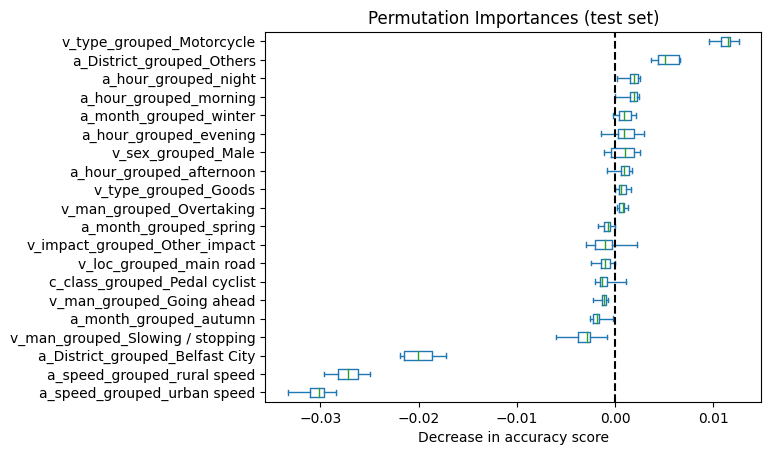

In [ ]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=train_features.columns[sorted_importances_idx],
)

sliced = importances.iloc[:,:10]
sliced = sliced.append(importances.iloc[:,-10:])

ax = sliced.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

In [ ]:
# feature_importance.plot(x='Feature', y='Importance',yerr='Standard Deviation', kind = 'barh')

### optimal threshold tuning

In [ ]:
yhat = model_lr_optim.predict_proba(test_features)
yhat = yhat[:, 1]
yhat

array([0.53608465, 0.49423925, 0.46132289, ..., 0.31978449, 0.61486187,
       0.58317516])

[1.98316306 0.98316306 0.97053478 ... 0.02723879 0.02713267 0.02498526]
Best Threshold=0.498397, G-Mean=0.718


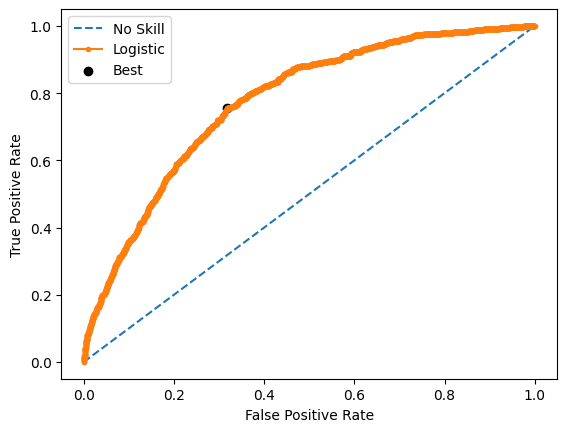

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from matplotlib import pyplot


# calculate roc curves
fpr, tpr, thresholds = roc_curve(test_labels, yhat)
print(thresholds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
pred_threshold = np.where(yhat >= 0.464725, 1,0)

In [ ]:

# roc_auc_score(test_labels, pred_threshold)

optim_thres_accuracy_lr = roc_auc_score(test_labels, pred_threshold)
optim_thres_f1_score_lr = f1_score(test_labels, pred_threshold)
optim_thres_roc_lr = roc_auc_score(test_labels, pred_threshold)
optim_thres_ap_lr = average_precision_score(test_labels, pred_threshold)

print(f"Accuracy: {optim_thres_accuracy_lr},f1 score: {optim_thres_f1_score_lr}, ROC: {optim_thres_roc_lr}, average precision: {optim_thres_ap_lr}")

In [ ]:
recall_score(test_labels, pred_threshold)

In [ ]:
confusion_matrix(test_labels, pred_threshold)

### with group cross validdation

In [ ]:
# df_ml_cv_features = df_ml.drop(['casualty_injury_type','collision_id'], axis = 1)
# df_ml_cv_labels = df_ml["casualty_injury_type"]
# groups = df_ml["collision_id"]

In [ ]:
accuracy_list = []
ROC_list = []
import collections
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler



# from sklearn.model_selection import GroupKFold
gkf_cv = GroupKFold(n_splits = 10)
for fold, (train_index, test_index) in enumerate(gkf_cv.split(cv_features,cv_labels,groups)):
    print(f"Fold {fold}")
    X_train = cv_features.iloc[train_index]
    y_train = cv_labels[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = cv_features.iloc[test_index]
    y_test = cv_labels[test_index]  # See comment on ravel and  y_train

    # # sm = SMOTE()
    # print(f"before over{Counter(y_train)}")
    # # X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    # # print(f"after smote {Counter(y_train_oversampled)}")

    # # over = RandomOverSampler(sampling_strategy=0.25)
    # # X_train_oversampled, y_train_oversampled = over.fit_resample(X_train, y_train)
    # # print(f"after over {Counter(y_train_oversampled)}")
    # under = RandomUnderSampler(sampling_strategy=0.5)
    # X_train_undersampled, y_train_undersampled = under.fit_resample(X_train, y_train)
    # print(f"after under {Counter(y_train_undersampled)}")

    model = LogisticRegression(max_iter=1000,penalty='l1', solver= 'liblinear',class_weight={0: w0, 1: w1})
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
#     print(f'For fold {fold}:')
#     print(f'Accuracy given: {model.score(X_test, y_test)}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy : {accuracy}")
    print(f'f1-score: {f1_score(y_test, y_pred,pos_label=0)}')
    roc = roc_auc_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    print(f"ROC score:{roc}")
    print(f"Average precision: {average_precision_score(y_test, y_pred,pos_label=0)}")
    print(f"confusion matrix:\n {conf_mat}")
    accuracy_list.append(accuracy)
    ROC_list.append(roc)
    # conf_mat_sum +=conf_mat



print(f"\nAverage accuracy: {np.mean(accuracy_list)}")
print(f"Average ROC: {np.mean(ROC_list)}")

Fold 0
Accuracy : 0.6860540540540541
f1-score: 0.7995582551076753
ROC score:0.7174499547573858
Average precision: 0.8919711149685079
confusion matrix:
 [[2896 1362]
 [  90  277]]
Fold 1
Accuracy : 0.6778378378378378
f1-score: 0.7925368978000558
ROC score:0.6900428203570291
Average precision: 0.8835303662144045
confusion matrix:
 [[2846 1369]
 [ 121  289]]
Fold 2
Accuracy : 0.6841081081081081
f1-score: 0.7965464419997215
ROC score:0.707544913759603
Average precision: 0.8804407628240156
confusion matrix:
 [[2860 1352]
 [ 109  304]]
Fold 3
Accuracy : 0.6985945945945946
f1-score: 0.8079360705428492
ROC score:0.714879951722057
Average precision: 0.8813154140359851
confusion matrix:
 [[2932 1286]
 [ 108  299]]
Fold 4
Accuracy : 0.6912432432432433
f1-score: 0.8019966722129783
ROC score:0.7158397628315465
Average precision: 0.8805405577928458
confusion matrix:
 [[2892 1324]
 [ 104  305]]
Fold 5
Accuracy : 0.6774054054054054
f1-score: 0.7929503191784625
ROC score:0.7068482968379057
Average prec

### with SMOTE

In [ ]:
smt = SMOTE()
print(Counter(train_labels))
train_features_overfitted, train_labels_overfitted = smt.fit_resample(train_features, train_labels)
print(Counter(train_labels_overfitted))

model_smt = LogisticRegression(max_iter=1000, C=0.1, penalty='l1', solver= 'liblinear',class_weight={0: w0, 1: w1})
model_smt.fit(train_features_overfitted, train_labels_overfitted)
pred_smt = model_smt.predict(test_features)

Counter({0: 33758, 1: 3115})
Counter({0: 33758, 1: 33758})


In [ ]:
accuracy_smt = accuracy_score(test_labels, pred_smt)
f1_score_smt = f1_score(test_labels, pred_smt)
roc_smt = roc_auc_score(test_labels, pred_smt)
ap_smt = average_precision_score(test_labels, pred_smt)
print(f"Accuracy: {accuracy_smt}, F1 score: {f1_score_smt},ROC: {roc_smt}, average precision: {ap_smt}")

Accuracy: 0.511469113410861, F1 score: 0.22638959283662782,ROC: 0.673677389001038, average precision: 0.12385622557161338


In [ ]:
confusion_matrix(test_labels, pred_smt)

array([[4124, 4477],
       [ 102,  670]])

In [ ]:
importance_smt = model_smt.coef_[0]
feature_importances_smt= [(feature, round(imp, 6)) for feature, imp in zip(train_features.columns, importance_smt)]
feature_importances_smt = sorted(feature_importances_smt, key = lambda x: x[1], reverse = True)
[print('Variable: {:50} Importance: {}'.format(*pair)) for pair in feature_importances_smt]

Variable: location_infos_lodging                             Importance: 0.126498
Variable: location_infos_university                          Importance: 0.0
Variable: c_class_grouped_Pedestrian                         Importance: 0.0
Variable: v_type_grouped_Motorcycle                          Importance: -0.000186
Variable: location_infos_car_repair                          Importance: -0.084853
Variable: location_infos_park                                Importance: -0.153162
Variable: location_infos_health                              Importance: -0.775479
Variable: v_type_grouped_Others                              Importance: -1.342847
Variable: v_sex_grouped_Male                                 Importance: -1.651876
Variable: v_loc_grouped_Bus lane / busway                    Importance: -1.737275
Variable: v_type_grouped_Car or Taxi                         Importance: -1.952106
Variable: v_sex_grouped_Other                                Importance: -1.956219
Variable: c_class

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Random forest

In [ ]:
# General model
# rf = RandomForestClassifier(n_estimators=100,random_state = 123,class_weight={0: w0, 1: w1})
rf = RandomForestClassifier(class_weight={0: w0, 1: w1})

# Train the model on training data
rf.fit(train_features, train_labels)
# Use the forest's predict method on the test data
pred_rf = rf.predict(test_features)

In [ ]:
accuracy_rf = accuracy_score(test_labels, pred_rf)
f1_score_rf = f1_score(test_labels, pred_rf)
roc_rf = roc_auc_score(test_labels, pred_rf)
ap_rf = average_precision_score(test_labels, pred_rf)
print(f"Accuracy: {accuracy_rf}, F1 score: {f1_score_rf}, ROC: {roc_rf}, average precision: {ap_rf}")

Accuracy: 0.8236423770404353, F1 score: 0.21022455805064502, ROC: 0.5784828610723058, average precision: 0.10635229161834428


In [ ]:
confusion_matrix(test_labels, pred_rf)

array([[7500, 1101],
       [ 552,  220]])

### hyperparameter tuning

In [ ]:
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid_rf = dict(n_estimators=n_estimators,max_features=max_features)

grid_rf_model = GridSearchCV(rf, param_grid = grid_rf,scoring = 'roc_auc')
grid_rf_result = grid_rf_model.fit(train_features, train_labels)

In [ ]:
print(grid_rf_result.best_estimator_)
print(f"Best score: {grid_rf_result.best_score_}")

RandomForestClassifier(class_weight={0: 0.5458816308222574,
                                     1: 5.948803704656547},
                       n_estimators=1000)
Best score: 0.6818161003855833


### optimal model

In [ ]:
rf_optim = RandomForestClassifier(n_estimators=1000, max_features='log2',class_weight={0: w0, 1: w1})# best estimator here

# Train the model on training data
rf_optim.fit(train_features, train_labels)
# Use the forest's predict method on the test data
pred_rf_optim = rf_optim.predict(test_features)

In [ ]:
optim_accuracy_rf = accuracy_score(test_labels, pred_rf_optim)
optim_f1_score_rf = f1_score(test_labels, pred_rf_optim,pos_label=0)
optim_roc_rf = roc_auc_score(test_labels, pred_rf_optim)
optim_ap_rf = average_precision_score(test_labels, pred_rf_optim,pos_label=0)
print(f"Accuracy: {optim_accuracy_rf}, F1 score: {optim_f1_score_rf}, ROC: {optim_roc_rf}, average precision: {optim_ap_rf}")

Accuracy: 0.822362103915502, F1 score: 0.8998255219300885, ROC: 0.5836806239544383, average precision: 0.9061944576820221


In [ ]:
confusion_matrix(test_labels, pred_rf_optim)

array([[7478, 1123],
       [ 542,  230]])

## One class SVM

In [ ]:
from sklearn.svm import OneClassSVM
# define outlier detection model
svm = OneClassSVM(gamma='scale', nu = 0.01)
# fit on majority class
train_features_0 = train_features[train_labels==0]
svm.fit(train_features_0)
# detect outliers in the test set
pred_svm = svm.predict(test_features)



In [ ]:
pred_svm

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
test_labels

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
# mark inliers 1, outliers -1
test_labels[test_labels == 1] = -1
test_labels[test_labels == 0] = 1

In [ ]:
accuracy_svm = accuracy_score(test_labels,pred_svm)
f1_score_svm = f1_score(test_labels, pred_svm, )
roc_auc_svm= roc_auc_score(test_labels, pred_svm)
ap_svm = average_precision_score(test_labels, pred_svm)
print(f"The accuracy is {accuracy_svm}, \nF1 score: {f1_score_svm} ,\nROC score is {roc_auc_svm}, \naverage precision is {ap_svm}")

The accuracy is 0.9093139869838899, 
F1 score: 0.9524182713837887 ,
ROC score is 0.5048982134262012, 
average precision is 0.9183767843817756


In [ ]:
confusion_matrix(test_labels, pred_svm)

array([[  16,  756],
       [  94, 8507]])

### hyperparameter tuning

In [ ]:
# kernel_svm = ['poly', 'rbf', 'sigmoid']
# grid_svm = dict(kernel=kernel_svm)

# grid_svm_model = GridSearchCV(svm, param_grid = grid_svm,scoring = 'roc_auc')
# grid_svm_result = grid_svm_model.fit(train_features, train_labels)

In [ ]:
# print(grid_svm_result.best_estimator_)
# print(f"Best score: {grid_svm_result.best_score_}")

OneClassSVM(kernel='poly', nu=0.01)
Best score: 0.47510092985577995


### optimal model

In [ ]:
svm_optim = OneClassSVM(gamma='scale', nu = 0.01,kernel='poly')
# fit on majority class
# train_features_0 = train_features[train_labels==0]
svm_optim.fit(train_features_0)
# detect outliers in the test set
pred_svm_optim = svm_optim.predict(test_features)
# mark inliers 1, outliers -1
# test_labels[test_labels == 1] = -1
# test_labels[test_labels == 0] = 1

In [ ]:
optim_accuracy_svm = accuracy_score(test_labels,pred_svm_optim)
optim_f1_score_svm = f1_score(test_labels, pred_svm_optim)
optim_roc_auc_svm= roc_auc_score(test_labels, pred_svm_optim)
optim_ap_svm = average_precision_score(test_labels, pred_svm_optim)
print(f"The accuracy is {optim_accuracy_svm}, \nF1 score: {optim_f1_score_svm} ,\nROC score is {optim_roc_auc_svm}, \naverage precision is {optim_ap_svm}")

The accuracy is 0.9063266830257122, 
F1 score: 0.950735046571653 ,
ROC score is 0.5073972450486237, 
average precision is 0.9187553203275153


In [ ]:
confusion_matrix(test_labels,pred_svm_optim)

array([[  23,  749],
       [ 129, 8472]])

## Isolaiton Forest

In [ ]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(n_estimators=100, contamination=.084)
IF.fit(train_features)
predictions = IF.predict(test_features)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
unique, counts = np.unique(predictions, return_counts=True)


dict(zip(unique, counts))

{-1: 762, 1: 8611}

In [ ]:
unique, counts = np.unique(test_labels, return_counts=True)


dict(zip(unique, counts))
# minority is -1, majority is 1


{0: 8601, 1: 772}

In [ ]:
# 1 => -1, 0=>1
test_labels_converted = list(map(lambda x: -1 if x == 1 else 1, test_labels))
# test_labels_converted


In [ ]:
unique, counts = np.unique(test_labels_converted, return_counts=True)
dict(zip(unique, counts))

{-1: 772, 1: 8601}

In [ ]:
accuracy = accuracy_score(test_labels_converted, predictions)
f1_score_lr = f1_score(test_labels_converted, predictions)
roc = roc_auc_score(test_labels_converted, predictions)
ap = average_precision_score(test_labels_converted, predictions)
print(f"Accuracy: {accuracy},f1 score: {f1_score_lr}, ROC: {roc}, average precision: {ap}")

Accuracy: 0.8630107756321349,f1 score: 0.9254008831048106, ROC: 0.5439279713830119, average precision: 0.9243282485658921


In [ ]:
recall_score(test_labels_converted, predictions)

0.9259388443204278

In [ ]:
precision_score(test_labels_converted, predictions)

0.9248635466264081

In [ ]:
confusion_matrix(test_labels_converted, predictions)

array([[ 125,  647],
       [ 637, 7964]])

### Hyperparameter Tuning


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
grid_lf = {'n_estimators': list(range(100, 800, 5)),
              'max_samples': list(range(100, 500, 5)),
              'max_features': [5,10,15],
              'bootstrap': [True, False],
              'n_jobs': [5, 10, 20, 30]}



gkf_cv_lf = list(GroupKFold(n_splits=5).split(cv_features, cv_labels,groups))
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# grid_lr = GridSearchCV(model, param_grid = grid,cv = gkf_cv,scoring = 'roc_auc')
# grid_result = grid_lr.fit(cv_features, cv_labels)


grid_lf_model = GridSearchCV(IF, param_grid = grid_lf,scoring = 'roc_auc', cv = gkf_cv_lf)
grid_lf_result = grid_lf_model.fit(cv_features, cv_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

KeyboardInterrupt: ignored

In [ ]:
print(grid_lf_result.best_estimator_)
print(f"Best score: {grid_lf_result.best_score_}")

### Optimal model

## Lime and Shap

In [ ]:
feature_list = train_features.columns

In [ ]:
# print([i for i in test_labels])
# for i in range(len(test_labels)):
#   print(f"{i}: {test_labels[i]}")
optim_pred_lr

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
# LIME is for single prediction explanation
# serious and fatal

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_features),
    feature_names=feature_list,
    class_names=['Slight','Serious and Fatal'],
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=test_features.iloc[9290],
    predict_fn=model_lr_optim.predict_proba
)

exp.show_in_notebook(show_table = True)

In [ ]:
# slight

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_features),
    feature_names=feature_list,
    class_names=['Slight', 'Serious and Fatal'],
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=test_features.iloc[1237],
    predict_fn=model_lr_optim.predict_proba
)

exp.show_in_notebook(show_table = True)

In [ ]:
cv_features.columns

Index(['location_infos_car_repair', 'location_infos_health',
       'location_infos_lodging', 'location_infos_park',
       'location_infos_university', 'a_month_grouped_autumn',
       'a_month_grouped_spring', 'a_month_grouped_summer',
       'a_month_grouped_winter', 'a_hour_grouped_afternoon',
       'a_hour_grouped_evening', 'a_hour_grouped_morning',
       'a_hour_grouped_night', 'a_District_grouped_Belfast City',
       'a_District_grouped_Fermanagh, Omagh', 'a_District_grouped_Mid Ulster',
       'a_District_grouped_Newry, Mourne, Down', 'a_District_grouped_Others',
       'v_man_grouped_Changing lane', 'v_man_grouped_Going ahead',
       'v_man_grouped_Other / not known', 'v_man_grouped_Overtaking',
       'v_man_grouped_Slowing / stopping', 'v_man_grouped_Stationary',
       'v_man_grouped_Turn or wait to turn', 'v_man_grouped_U-turn',
       'v_loc_grouped_Bus lane / busway', 'v_loc_grouped_Footpath (pavement)',
       'v_loc_grouped_On minor road', 'v_loc_grouped_lay-by/har

In [ ]:
cv_features = cv_features.rename(columns={"v_impact_grouped_Other_impact": "First point of impact (except front point of impact)",
                            "a_speed_grouped_urban speed": "Speed Limit under or equal to 30mph",
                            "a_District_grouped_Belfast City":"Belfast City Policing Area",
                            "a_speed_grouped_rural speed":"Speed Limit over 30mph",
                            "v_man_grouped_Slowing / stopping":"Vehicle is slowing/stopping",
                            "v_type_grouped_Motorcycle":"Vehicle Type: Motorcycle",
                            "v_agegroup_grouped_The yonger and elder":"Driver aged over 55 and between 10 and 24",
                            "v_sex_grouped_Male":"Male Driver",
                            "c_class_grouped_Pedal cyclist":"Casualty class: Pedal cyclist",
                            "v_type_grouped_Others":"Other Vehicle Types",
                            "a_hour_grouped_evening": "Collisions happened batween 19pm to 24pm",
                            "a_District_grouped_Others":"Other Policing Area",
                            "a_hour_grouped_night":"Collisions happened between 1am to 6am",
                            "c_class_grouped_Vehicle passenger":"Casualty class: Vehicle passenger",
                            "v_sex_grouped_Other":"Female and unknown gender Driver",
                            "v_man_grouped_Turn or wait to turn":"Vehicle is turning or waiting to turn",
                            "a_hour_grouped_morning":"Collisions happened between 7am to 12 o'clock",
                            "a_District_grouped_Fermanagh, Omagh":"Fermanagh, Omagh Policing Area",
                            "v_loc_grouped_main road":"Vehicle is leaving/entering/on the main road",
                            "a_month_grouped_winter":"Season Winter",
                            "v_type_grouped_Car or Taxi":"Car or Taxi"
                            })

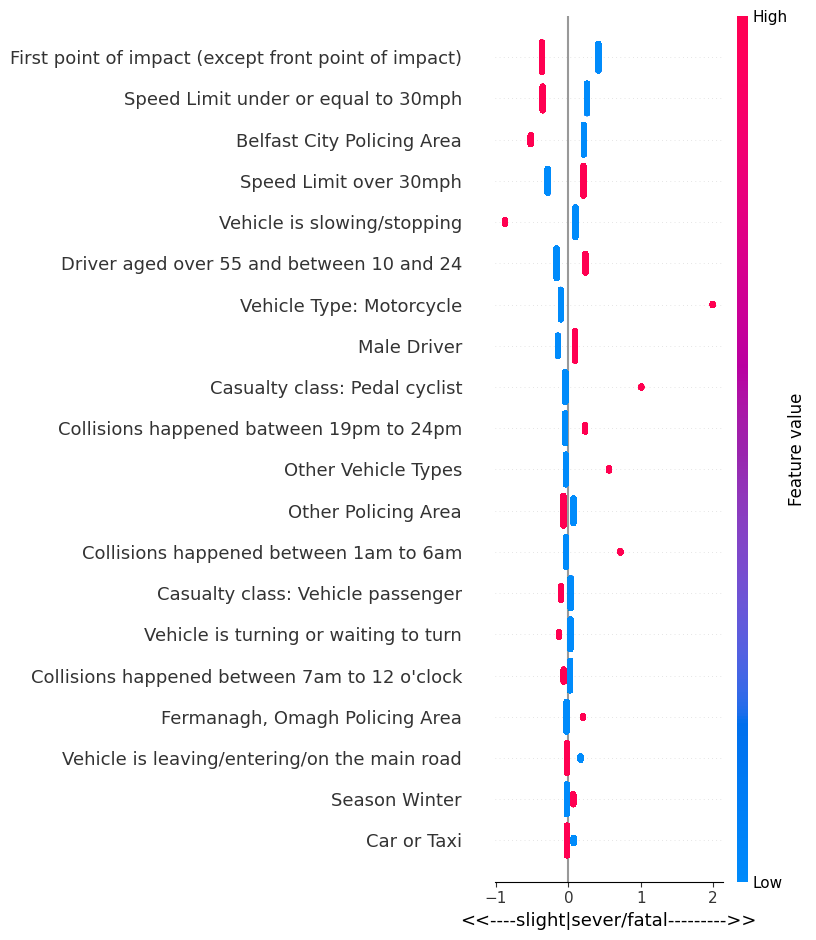

In [ ]:
# SHAP is used for entire model explanation



explainer = shap.LinearExplainer(model_lr_optim,cv_features)
shap_values = explainer.shap_values(cv_features)

shap.summary_plot(shap_values,cv_features, show = False)
plt.xlabel("<<----slight|sever/fatal--------->>")
plt.show()
